<a href="https://colab.research.google.com/github/bchuchucaa/RNNConsumoDeAgua/blob/main/RNNConsumoDeAgua.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip /content/archive.zip

unzip:  cannot find or open /content/archive.zip, /content/archive.zip.zip or /content/archive.zip.ZIP.


In [1]:
from pandas import read_csv
from datetime import datetime
import pandas as pd
from matplotlib import pyplot
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import model_from_json
from sklearn.metrics import mean_squared_error
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import scale 

print('LIBRERIAS IMPORTADAS')

LIBRERIAS IMPORTADAS


**LECTURA DE DATOS**

In [2]:
#LOADING DATA 
number_of_samples=int(input("INGRESE EL NUMERO DE MUESTRAS"))
df= read_csv('/content/AguaH.csv')
df = df.iloc[0:number_of_samples , :]
#AJUSTE DEL FORMATO DE LAS FECHAS 
lookup = {'ENE':'01','FEB':'02','MAR':'03','ABR':'04','MAY':'05','JUN':'06','JUL':'07','AGO':'08','SEP':'09','OCT':'10','NOV':'11','DIC':'12'}
clist=[]
for col in df.columns[5:]:
    col = col[4:].split('_')
    clist.append('20'+col[1]+'-'+lookup[col[0]]+'-01')

columns = ['LANDUSE_TYPE','USER','PIPE DIAM','VENDOR','JAN16']+clist
df.columns=columns
df = df.drop(columns=['LANDUSE_TYPE','PIPE DIAM','VENDOR','JAN16'])
#ESTE CODIGO SIRVE UNICAMENTE PARA LA INTEGRACION DE LOS NOMBRES EN EL DATAFRAME
names = pd.read_csv("/content/StateNames.csv", usecols=["Name"])
names = names.iloc[0:number_of_samples , :]
#ELIMINAMOS LA COLUMNA DE LOS NOMBRE YA QUE SE BINARIZARON
print("Names shape ",names.shape)
df.insert(loc=1, column='Names', value=names)
print("Dataframe shape ",df.shape)
#AJUSTE DEL DATASET EN EL FORMATO SOLICITADO 
rows_list=[]
dataComp = pd.DataFrame(columns=('DATE','NOMBRE','TIPO', 'CONSUMO'))
for column in range(2,len(df.columns),1):
  selection=df.iloc[:,column]
  for row in range(len(selection)):
    df2=[df.columns[column],df.iloc[row,1],df.iloc[row,0],selection.iloc[row]]
    rows_list.append(df2)
    
dataComp = pd.DataFrame(rows_list)  


INGRESE EL NUMERO DE MUESTRAS7000
Names shape  (7000, 1)
Dataframe shape  (7000, 86)


In [3]:
dataComp.tail()

,0,1,2,3
587995,2015-12-01,Victoria,DOMESTICO RESIDENCIAL,0.0
587996,2015-12-01,Audrey,DOMESTICO RESIDENCIAL,10.0
587997,2015-12-01,Candace,DOMESTICO MEDIO,24.0
587998,2015-12-01,Janice,DOMESTICO RESIDENCIAL,6.0
587999,2015-12-01,Joanna,DOMESTICO MEDIO,10.0


In [4]:
dataComp.rename(columns = {0:'DATE',1:'NOMBRE',2:'TIPO',3:'CONSUMO'}, inplace = True)
dataComp['DATE'] = pd.to_datetime(dataComp['DATE'], format='%Y-%m-%d')
dataComp=dataComp.set_index('DATE')
#RANGO DE FECHAS DE LAS MUESTRAS
print(dataComp.index.min())
print(dataComp.index.max())
#CANTIDAD DE MUESTRAS POR ANIO
print(len(dataComp['2009']))


2009-01-01 00:00:00
2015-12-01 00:00:00
84000


In [5]:
#DESCRIPCION DEL DATASET
dataComp.describe()

,CONSUMO
count,438765.000000
mean,122.771406
std,992.457554
min,0.000000
25%,9.000000
50%,15.000000
75%,23.000000
max,100302.000000


In [6]:
#RELLENANDO VALORES NAN POR LA MEDIA
dataComp=dataComp.fillna(dataComp['CONSUMO'].mean())
salida=dataComp["CONSUMO"]
dataComp = dataComp.drop('CONSUMO',axis = 1)
dataComp.head()

,NOMBRE,TIPO
DATE,,
2009-01-01,Mary,DOMESTICO MEDIO
2009-01-01,Annie,DOMESTICO MEDIO
2009-01-01,Anna,DOMESTICO RESIDENCIAL
2009-01-01,Margaret,DOMESTICO MEDIO
2009-01-01,Helen,DOMESTICO RESIDENCIAL


In [7]:
# Create a categorical boolean mask
categorical_feature_mask = dataComp.dtypes == object
# Filter out the categorical columns into a list for easy reference later on in case you have more than a couple categorical columns
categorical_cols = dataComp.columns[categorical_feature_mask].tolist()

# Instantiate the OneHotEncoder Object
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse = False)
dataComp['TIPO'] = dataComp['TIPO'].astype(str)
dataComp['NOMBRE'] = dataComp['NOMBRE'].astype(str)

# Apply ohe on data
ohe.fit(dataComp[categorical_cols])
cat_ohe = ohe.transform(dataComp[categorical_cols])

#Create a Pandas DataFrame of the hot encoded column
ohe_df = pd.DataFrame(cat_ohe, columns = ohe.get_feature_names(input_features = categorical_cols))
#concat with original data and drop original columns


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [8]:
#PCA Projection to 2D
from sklearn.decomposition import PCA
num_components=5
columnas=['PC1','PC2','PC3','PC4','PC5']
pca = PCA(num_components)
principalComponents = pca.fit_transform(ohe_df)
principalDf = pd.DataFrame(data = principalComponents
             , columns = columnas)
principalDf=round(principalDf, 2)
print(principalDf)

         PC1   PC2   PC3   PC4   PC5
0      -0.56 -0.11 -0.02 -0.01  0.95
1      -0.55 -0.11 -0.02 -0.00 -0.00
2       0.84 -0.32 -0.05 -0.03 -0.06
3      -0.55 -0.10 -0.02 -0.01 -0.26
4       0.84 -0.32 -0.05 -0.03 -0.03
...      ...   ...   ...   ...   ...
587995  0.84 -0.31 -0.05 -0.03 -0.00
587996  0.84 -0.32 -0.05 -0.03 -0.00
587997 -0.56 -0.11 -0.02 -0.01 -0.00
587998  0.84 -0.32 -0.05 -0.02 -0.00
587999 -0.55 -0.11 -0.02 -0.01 -0.00

[588000 rows x 5 columns]


In [9]:
principalDf.index=dataComp.index
principalDf.insert(loc=5, column='CONSUMO', value=salida)
principalDf.rename(columns = {0:'PC1',1:'PC2',2:'PC3',3:'PC4',4:'PC5'}, inplace = True)
principalDf.head()


,PC1,PC2,PC3,PC4,PC5,CONSUMO
DATE,,,,,,
2009-01-01,-0.56,-0.11,-0.02,-0.01,0.95,20.000000
2009-01-01,-0.55,-0.11,-0.02,-0.00,-0.00,122.771406
2009-01-01,0.84,-0.32,-0.05,-0.03,-0.06,122.771406
2009-01-01,-0.55,-0.10,-0.02,-0.01,-0.26,122.771406
2009-01-01,0.84,-0.32,-0.05,-0.03,-0.03,20.000000


In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
principalDf = scaler.fit_transform(principalDf.values)

In [12]:
principalDf = pd.DataFrame(principalDf)

In [13]:
principalDf.rename(columns = {0:'PC1',1:'PC2',2:'PC3',3:'PC4',4:'PC5',5:'CONSUMO'}, inplace = True)
principalDf.head()

,PC1,PC2,PC3,PC4,PC5,CONSUMO
0,0.000000,0.168,0.321168,0.182540,1.000000,0.000199
1,0.007092,0.168,0.321168,0.190476,0.221311,0.001224
2,0.992908,0.000,0.299270,0.166667,0.172131,0.001224
3,0.007092,0.176,0.321168,0.182540,0.008197,0.001224
4,0.992908,0.000,0.299270,0.166667,0.196721,0.000199


In [14]:
#Split en x, y
y=principalDf['CONSUMO']
dataset=principalDf.drop(['CONSUMO'], axis=1)
x=dataset
values = dataset.values
x

,PC1,PC2,PC3,PC4,PC5
0,0.000000,0.168,0.321168,0.182540,1.000000
1,0.007092,0.168,0.321168,0.190476,0.221311
2,0.992908,0.000,0.299270,0.166667,0.172131
3,0.007092,0.176,0.321168,0.182540,0.008197
4,0.992908,0.000,0.299270,0.166667,0.196721
...,...,...,...,...,...
587995,0.992908,0.008,0.299270,0.166667,0.221311
587996,0.992908,0.000,0.299270,0.166667,0.221311
587997,0.000000,0.168,0.321168,0.182540,0.221311
587998,0.992908,0.000,0.299270,0.174603,0.221311


In [15]:
# asegurarse que todo esta en formato float
values = values.astype('float32')
# normalzación
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
scaled= values

In [16]:
##red neuronal estandar
numregistros=scaled.shape[0]
print(numregistros)

# split en conjuntos de train y test
n_train = int(round(numregistros*0.8,0)) #80% para entrenamiento
train_X = scaled[:n_train, :]
test_X = scaled[n_train:, :]
train_y = y[:n_train]
test_y = y[n_train:]

# reshape entrada a 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

588000
(470400, 1, 5) (470400,) (117600, 1, 5) (117600,)


Epoch 1/50
23520/23520 - 117s - loss: 6.5178e-05 - val_loss: 8.3786e-05 - 117s/epoch - 5ms/step
Epoch 2/50
23520/23520 - 114s - loss: 6.3926e-05 - val_loss: 8.3163e-05 - 114s/epoch - 5ms/step
Epoch 3/50
23520/23520 - 114s - loss: 6.3886e-05 - val_loss: 8.3664e-05 - 114s/epoch - 5ms/step
Epoch 4/50
23520/23520 - 116s - loss: 6.3781e-05 - val_loss: 8.3916e-05 - 116s/epoch - 5ms/step
Epoch 5/50
23520/23520 - 113s - loss: 6.3640e-05 - val_loss: 8.4296e-05 - 113s/epoch - 5ms/step
Epoch 6/50
23520/23520 - 110s - loss: 6.3590e-05 - val_loss: 8.3805e-05 - 110s/epoch - 5ms/step
Epoch 7/50
23520/23520 - 119s - loss: 6.3421e-05 - val_loss: 8.4054e-05 - 119s/epoch - 5ms/step
Epoch 8/50
23520/23520 - 121s - loss: 6.3146e-05 - val_loss: 8.3532e-05 - 121s/epoch - 5ms/step
Epoch 9/50
23520/23520 - 107s - loss: 6.2766e-05 - val_loss: 8.3464e-05 - 107s/epoch - 5ms/step
Epoch 10/50
23520/23520 - 123s - loss: 6.2289e-05 - val_loss: 8.3208e-05 - 123s/epoch - 5ms/step
Epoch 11/50
23520/23520 - 107s - loss: 

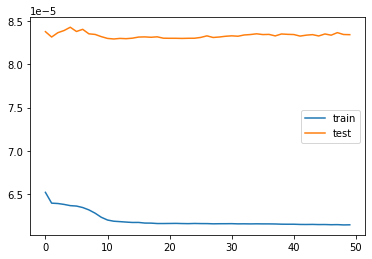

In [26]:
# Diseño de la red recurrente LSTM
model = Sequential()
model.add(LSTM(256, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# entrenar red
history = model.fit(train_X, train_y, epochs=50, batch_size=20, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [18]:
y_pred= model.predict(test_X)
mean_squared_error(test_y, y_pred)

9.770761492003513e-05

In [22]:
complete=train_X[1:2,:]
pred_X = train_X[1:2, :-1]
print(pred_X)
print(complete)
new = pred_X.reshape((pred_X.shape[0], 1, pred_X.shape[1]))
print(new)

[]
[[[0.0070922  0.168      0.3211679  0.1904762  0.22131148]]]
[]


In [24]:
# predict on df_ohe_new
predict = model.predict(test_X)
print(predict[0][0])

-0.0026701204


In [25]:
predict

array([[-0.00267012],
       [-0.00146712],
       [-0.00319162],
       ...,
       [-0.00319162],
       [-0.00564108],
       [-0.00267013]], dtype=float32)

In [ ]:
scaler.inverse_transform(complete)

In [ ]:
results=model.predict(x_val)
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

In [ ]:
ultimosDias = dataComp['2015-11-01':'2015-12-31']
ultimosDias

In [ ]:
values = reframed.values
x_test = values[6:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
x_test

In [ ]:
prediccion1SemanaDiciembre = pd.DataFrame(inverted)
prediccion1SemanaDiciembre.columns = ['pronostico']
prediccion1SemanaDiciembre.plot()
prediccion1SemanaDiciembre.to_csv('pronostico.csv')

In [ ]:
# Diseño de la red recurrente LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(128))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
model.summary()

In [ ]:
pd.DataFrame(test_y)

In [ ]:
y_pred.shape

In [ ]:
tes

In [ ]:
mean_squared_error(test_y, y_pred, squared=False)

In [ ]:
 # serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 
# later...
 
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model.h5")
print("Loaded model from disk")
 

In [ ]:
#FUNCION PARA ESCOGER UN REGISTRO DENTRO DEL DATAFRAME PARA LAS PRUEBAS DE VALIDACION
def selectRabbit(user):
  xnew = dataComp.iloc[user , 1:999]
  return xnew


In [ ]:
#FUNCION PARA BUSCAR EL VALOR REAL DE CONSUMO DENTRO DEL DATAFRAME
def searchForReal(user):
  real= dataComp.iloc[user ,-1]
  return real

In [ ]:
user=dataComp.iloc[-1,1:]

In [ ]:
user.shape

In [ ]:
def prediccion(user):
    Xnew = np.array([dataComp.iloc[-1,1:]])#real es 79
    print(Xnew.shape)
    #xnew=selectRabbit(user)
    Xnew= scaler.transform(Xnew)
    Xnew = Xnew.reshape((Xnew.shape[0], 1, Xnew.shape[1]))
    print(Xnew.shape)
    pred= model.predict(Xnew)[0]
    return pred
    
pred=prediccion(83)
print('PREDICCION DE CONSUMO: ',pred)
#print('USUARIO CONSUMO REAL :  [',searchForReal(83),']')

In [ ]:
plt.plot(meses['2009'].values)
plt.plot(meses['2010'].values)

In [ ]:
verano2009 = dataComp['2009-01-01':'2009-01-31']
plt.plot(verano2009.values)
verano2010 = dataComp['2010-01-01':'2010-01-31']
plt.plot(verano2010.values)

In [ ]:
import matplotlib.pyplot as plt
steps = 14400
datos_train = dataComp[:-steps]
datos_test  = dataComp[-steps:]
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
ax.legend();